In [3]:
import argparse
import isce
import isceobj
import os
from osgeo import gdal
from osgeo import gdal_array
import numpy as np
import xml.etree.ElementTree as ET
import glob
import rasterio as rio

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


In [4]:
###Folowing files need to be the same size as your output grid.
latfile  = '/data/krd86/cropped/geom_reference/lat.rdr.4alks_20rlks.full.vrt'
lonfile  = '/data/krd86/cropped/geom_reference/lon.rdr.4alks_20rlks.full.vrt'

In [8]:
resampMethod = 'near'
workdir      = '/data/krd86/cropped/NDVI/'
cropdir  = workdir+'cropped/' 
#os.mkdir(cropdir) # needs to exist and be empty
radardir = workdir+'radar/'
#os.mkdir(radardir) # needs to exist and be empty
infiles      = glob.glob(workdir+'NDVI*tif')
infiles      = sorted(infiles)
infile       = infiles[0] # file for getting bounds, data type.  Assumes all others are on same grid
os.chdir(workdir) # change to NDVI dir

In [5]:
# reproject to WGS 84 if needed
with rio.open(infile) as ds:
    sar_bounds = ds.bounds
    crs = ds.crs
if crs != rio.crs.CRS.from_epsg(4326):
    reprojdir = workdir+'reproj/'
    os.mkdir(reprojdir) # needs to exist and be empty
    for file in infiles:
        reprojfile = reprojdir+os.path.basename(file)
        cmd = 'gdalwarp '+file+' '+reprojfile+' -t_srs "+proj=longlat +ellps=WGS84"'
        os.system(cmd)
    # use files in WGS 84 as the grid    
    infiles      = glob.glob(reprojdir+'NDVI*tif')
    infiles      = sorted(infiles)
    infile       = infiles[0] # file for getting bounds, data type.  Assumes all others are on same grid    

2022-10-26 11:39:48,197 - rasterio.env - DEBUG - Entering env context: <rasterio.env.Env object at 0x7fa9480e86d0>
2022-10-26 11:39:48,202 - rasterio.env - DEBUG - Starting outermost env
2022-10-26 11:39:48,203 - rasterio.env - DEBUG - No GDAL environment exists
2022-10-26 11:39:48,204 - rasterio.env - DEBUG - New GDAL environment <rasterio._env.GDALEnv object at 0x7fa948a6aee0> created
2022-10-26 11:39:48,206 - rasterio._env - DEBUG - GDAL_DATA found in environment.
2022-10-26 11:39:48,207 - rasterio._env - DEBUG - PROJ_LIB found in environment.
2022-10-26 11:39:48,208 - rasterio._env - DEBUG - Started GDALEnv: self=<rasterio._env.GDALEnv object at 0x7fa948a6aee0>.
2022-10-26 11:39:48,209 - rasterio.env - DEBUG - Entered env context: <rasterio.env.Env object at 0x7fa9480e86d0>
2022-10-26 11:39:48,210 - rasterio._base - DEBUG - Sharing flag: 0
2022-10-26 11:39:48,242 - rasterio._base - DEBUG - Nodata success: 0, Nodata value: -10000000000.000000
2022-10-26 11:39:48,243 - rasterio._base

In [6]:
infile

'/data/krd86/cropped/NDVI/reproj/NDVI_Landsat_masked_2019.tif'

In [7]:
###figure out bounds of lat/lonfile and crop input file
lf = gdal.Open(latfile)
stats = lf.GetRasterBand(1).GetStatistics(0,1)
sarMinLat = stats[0]
sarMaxLat = stats[1]
lf=None

###figure out bounds of lat/lonfile and crop input file
lf = gdal.Open(lonfile)
stats = lf.GetRasterBand(1).GetStatistics(0,1)
sarMinLon = stats[0]
sarMaxLon = stats[1]
lf=None

###get pixel spacing on infile
lf    = gdal.Open(infile)
stats = lf.GetGeoTransform()
dLon  = stats[1]
dLat  = -stats[5]
band = lf.GetRasterBand(1)
arr = band.ReadAsArray()
dtype = gdal.GetDataTypeName(band.DataType)
print(dtype)
#plt.imshow(arr)
#plt.show()
lf   = None

Float32


In [8]:
###Crop file to one pixel wider than extent of radar coordinates data
for file in infiles:
    cropfile = cropdir+os.path.basename(file)
    cmd = 'gdalwarp -te '+str(sarMinLon-dLon)+' '+str(sarMinLat-dLat)+' '+str(sarMaxLon+dLon)+' '+str(sarMaxLat+dLat)+' '+file+' '+cropfile
    os.system(cmd)
    ###build a vrt file for our tiff
    cmd='gdalbuildvrt '+cropfile+'.vrt '+cropfile
    os.system(cmd)

Creating output file that is 4136P x 1947L.
Processing /data/krd86/cropped/NDVI/reproj/NDVI_Landsat_masked_2019.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 4136P x 1947L.
Processing /data/krd86/cropped/NDVI/reproj/NDVI_Landsat_masked_2020.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 4136P x 1947L.
Processing /data/krd86/cropped/NDVI/reproj/NDVI_Landsat_masked_2021.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [9]:
def writeVRT(infile, latFile, lonFile):
#This function is modified from isce2gis.py
            tree = ET.parse(infile + '.vrt')
            root = tree.getroot()

            meta = ET.SubElement(root, 'metadata')
            meta.attrib['domain'] = "GEOLOCATION"
            meta.tail = '\n'
            meta.text = '\n    '


            rdict = { 'Y_DATASET' : latFile,
                      'X_DATASET' : lonFile,
                      'X_BAND' : "1",
                      'Y_BAND' : "1",
                      'PIXEL_OFFSET': "0",
                      'LINE_OFFSET' : "0",
                      'LINE_STEP' : "1",
                      'PIXEL_STEP' : "1" }

            for key, val in rdict.items():
                data = ET.SubElement(meta, 'mdi')
                data.text = val
                data.attrib['key'] = key
                data.tail = '\n    '

            data.tail = '\n'
            tree.write(infile + '.vrt')

In [10]:
##get number of rows and columns in radar coords file (lat)
raster = gdal.Open(latfile)
radarnx=raster.RasterXSize
radarny=raster.RasterYSize
cols,rows=np.meshgrid(np.arange(1,radarnx+1),np.arange(radarny,0,-1))

#make new files of columns and rows, in radar coordinates
colfile = 'cols.r4'
rowfile = 'rows.r4'
gcolfile = 'geo_colscropscape.r4'
growfile = 'geo_rowscropscape.r4'
driver=gdal.GetDriverByName('ISCE')
colds = driver.Create(colfile,radarnx,radarny,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(cols)
colds=None

colds = driver.Create(rowfile,radarnx,radarny,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(rows)
colds=None

cmd = 'fixImageXml.py -i '+colfile+' -f'
os.system(cmd)
cmd = 'fixImageXml.py -i '+rowfile+' -f'
os.system(cmd)
writeVRT(colfile, latfile, lonfile)
writeVRT(rowfile, latfile, lonfile)

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


In [11]:
##get number of rows and columns + min/max range of input file
cropfile = cropdir+os.path.basename(infile)
raster = gdal.Open(cropfile)
geonx=raster.RasterXSize
geony=raster.RasterYSize

minLon = raster.GetGeoTransform()[0]
deltaLon = raster.GetGeoTransform()[1]
maxLat = raster.GetGeoTransform()[3]
deltaLat = raster.GetGeoTransform()[5]
minLat = maxLat + geony*deltaLat
maxLon = minLon + geonx*deltaLon
WSEN = str(minLon)+' '+str(minLat)+' '+str(maxLon)+' '+str(maxLat)


In [12]:
#geocode row and col file
cmd = 'gdalwarp -of ISCE -geoloc  -te '+WSEN+' -tr '+str(deltaLon)+' '+str(deltaLat)+' -srcnodata 0 -dstnodata 0  -wt float32 -r bilinear ' +rowfile +'.vrt ' + growfile
print(cmd)
os.system(cmd)
cmd = 'gdalwarp -of ISCE -geoloc  -te '+WSEN+' -tr '+str(deltaLon)+' '+str(deltaLat)+' -srcnodata 0 -dstnodata 0  -wt float32 -r bilinear ' +colfile +'.vrt ' + gcolfile
print(cmd)
os.system(cmd)
cmd = 'gdalbuildvrt '+gcolfile+'.vrt '+gcolfile
os.system(cmd)
cmd = 'gdalbuildvrt '+growfile+'.vrt '+growfile
os.system(cmd)

gdalwarp -of ISCE -geoloc  -te -120.36264088072315 35.709032369495844 -119.09244464142685 36.30709591115815 -tr 0.0003071074079536501 -0.00030717182417170307 -srcnodata 0 -dstnodata 0  -wt float32 -r bilinear rows.r4.vrt geo_rowscropscape.r4
Creating output file that is 4136P x 1947L.
Processing rows.r4.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
gdalwarp -of ISCE -geoloc  -te -120.36264088072315 35.709032369495844 -119.09244464142685 36.30709591115815 -tr 0.0003071074079536501 -0.00030717182417170307 -srcnodata 0 -dstnodata 0  -wt float32 -r bilinear cols.r4.vrt geo_colscropscape.r4
Creating output file that is 4136P x 1947L.
Processing cols.r4.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [13]:
###set any geocoding info
WSEN = '0.5 0.5 '+str(radarnx+0.5)+' '+str(radarny+0.5)
for file in infiles:
    cropfile = cropdir+os.path.basename(file)
    outfile  = radardir+os.path.basename(file)
    writeVRT(cropfile, growfile, gcolfile)
    cmd = 'gdalwarp -geoloc -of ISCE -te '+ WSEN + ' -tr 1 1 -srcnodata 0 -dstnodata 0 -wt '+dtype+' -r ' + resampMethod + ' ' + cropfile +'.vrt ' +outfile
    os.system(cmd)
    cmd = 'gdalbuildvrt '+outfile+'.vrt '+outfile
    os.system(cmd)

Creating output file that is 1500P x 875L.
Processing /data/krd86/cropped/NDVI/cropped/NDVI_Landsat_masked_2019.tif.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1500P x 875L.
Processing /data/krd86/cropped/NDVI/cropped/NDVI_Landsat_masked_2020.tif.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1500P x 875L.
Processing /data/krd86/cropped/NDVI/cropped/NDVI_Landsat_masked_2021.tif.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [14]:
cmd = 'gdalwarp -geoloc  -te '+ WSEN + ' -tr 1 1 -srcnodata 0 -dstnodata 0 -wt byte -r ' + resampMethod + ' ' + croppedInfile +'.vrt ' +outfile
print (cmd)
os.system(cmd)
#cmd = 'fixImageXml.py -i '+outfiles+' -f'
#os.system(cmd)

NameError: name 'croppedInfile' is not defined

Check if ungeocoding worked

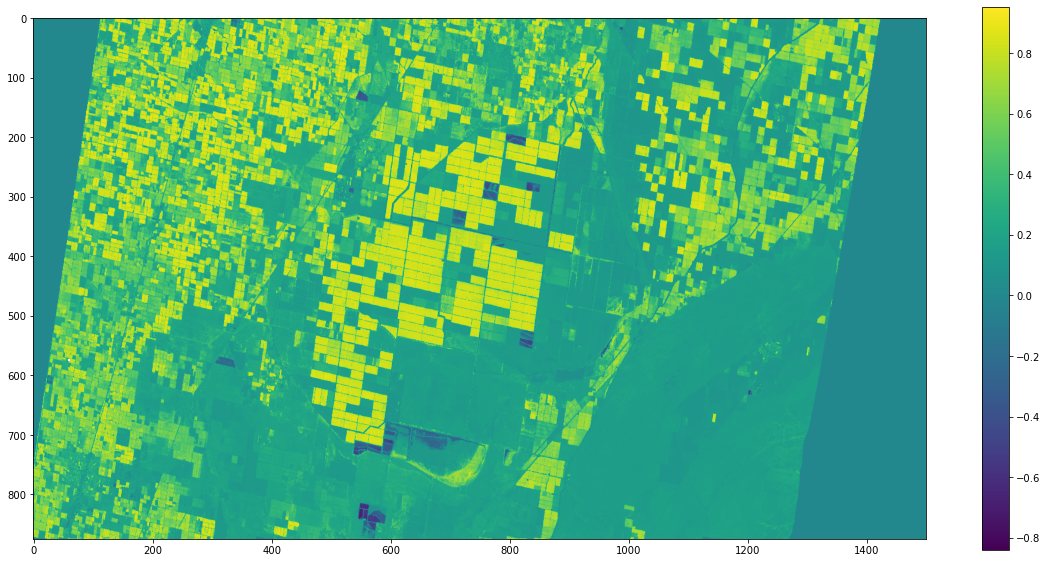

In [14]:
from osgeo import gdal
import matplotlib.pyplot as plt

ds = gdal.Open('/data/krd86/cropped/NDVI/radar/NDVI_Landsat_masked_2019.tif')
test = ds.GetRasterBand(1).ReadAsArray()

fig = plt.figure(figsize=(20,10))
plt.imshow(test)
plt.colorbar()

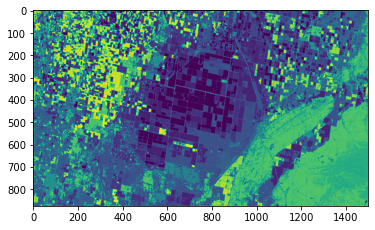

In [12]:
ds = gdal.Open('/data/krd86/cropped/cropscape/radar/CDL_2008_clip_20220408094633_39327711.tif')
test = ds.GetRasterBand(1).ReadAsArray()

fig = plt.figure(figsize=(20,10))
plt.imshow(test)